# Make gradient feature

Example of how a feature is built. This notebook goes through each step in the `build_features_by_dt` function (and its components) in `releat/data/pipeline.py` script

## PREREQUISITE - Download tick data

Before running this notebook, download tick data from brokers by running the following command from within the docker container: 

`/.venv/bin/python /workspaces/releat/workflows/download_mt5_data.py`

Alternatively, you can run it from your local terminal and execute on your docker container, replace `<container-name>` with the name of the container, which should either be `releat` or `releat-dc` depending on how you set it up:

`docker exec -it <container-name> /.venv/bin/python /workspaces/releat/workflows/download_mt5_data.py`

In [1]:
from releat.utils.logging import get_logger
from releat.utils.configs.config_builder import load_config
from releat.data.pipeline import load_raw_tick_data
from releat.data.cleaning import group_tick_data_by_time
from releat.data.simple.stats import calc_gradient_feature
from releat.data.cleaning import fill_trade_interval
from releat.data.transformers import get_transform_params
import logging
import polars as pl
import pandas as pd
logger = get_logger(__name__, log_level=logging.INFO)

## Load feature config and data

- For this example, see /agents/t00001/feature_config.py
- The load_config function validates configs via pydantic as well as combines all the other config files in the /agents/t00001 folder

In [2]:
config = load_config('t00001')

In [3]:
# Index of the feature group - in this case we want the 5m timeframe
feat_group_ind = 1

# Index of the feature within the feature group
feat_ind = 3

feat_group = config.features[feat_group_ind]
fc = feat_group.simple_features[feat_ind]

# the simple config that defines a single feature (conversion to dict is for printing only)
dict(fc)

{'name': 'grad',
 'broker': 'metaquotes',
 'index': 3,
 'symbol': 'EURUSD',
 'timeframe': '5m',
 'inputs': ['avg_price'],
 'output_shape': (3, 1),
 'timeframe_mode': 'rolling',
 'kwargs': {'min_num': 10},
 'fillna': 'zero',
 'transforms': [TransformerConfig(name='clip', method='percentile', upper_lim=99.9, lower_lim=0.1, scale_factor=1, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None),
  TransformerConfig(name='scale', method='PowerTransformer', upper_lim=None, lower_lim=None, scale_factor=None, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=True),
  TransformerConfig(name='scale', method='PiecewiseLinear', upper_lim=None, lower_lim=None, scale_factor=None, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None),
  TransformerConfig(name='clip', method='value', upper_lim=3, lower_lim=-3, scale_factor=0.5, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None)]}

In [4]:
# load tick data
dt = '2023-06-01'
symbol = fc.symbol
broker = fc.broker
tick_df = load_raw_tick_data(config, broker, symbol, dt)

# For this example, reduce sample size so that it runs quickly
tick_df = tick_df.head(100_000)

# Note that this is a polars dataframe
tick_df.head(10)

bid,ask,time_msc,avg_price,spread,time_diff,flags
f32,f32,datetime[ns],f32,f32,f32,i32
1.0733,1.07351,2023-05-31 00:01:27.515,1.073405,0.00021,null,6
1.07244,1.07344,2023-05-31 00:01:27.515,1.07294,0.001,0.0,6
1.07244,1.07344,2023-05-31 00:02:00.004,1.07294,0.001,32.488998,2
1.07244,1.07344,2023-05-31 00:03:17.075,1.07294,0.001,60.0,6
1.07244,1.07338,2023-05-31 00:03:47.987,1.07291,0.00094,30.912001,4
1.07243,1.07338,2023-05-31 00:04:12.446,1.072905,0.00095,24.459,2
1.07238,1.07338,2023-05-31 00:04:42.989,1.07288,0.001,30.542999,2
1.0724,1.07338,2023-05-31 00:04:59.963,1.07289,0.00098,16.974001,6
1.07245,1.07343,2023-05-31 00:05:00.079,1.07294,0.00098,0.116,6


In [5]:
df_group = group_tick_data_by_time(config, feat_group_ind, tick_df)

# Print some summary statistics
summary = df_group.agg(
    [
        pl.col("time_msc").min().alias("min_datetime"),
        pl.col("time_msc").max().alias("max_datetime"),
        pl.col("time_msc").count().alias("num_ticks"),
        pl.col("avg_price").last().alias("price")
    ]
)
summary.head(10)

time_msc,min_datetime,max_datetime,num_ticks,price
datetime[ns],datetime[ns],datetime[ns],u32,f32
2023-05-31 00:01:20,2023-05-31 00:01:24.515,2023-05-31 00:06:14.865,31,1.073285
2023-05-31 00:01:30,2023-05-31 00:01:57.004,2023-05-31 00:06:28.442,31,1.07331
2023-05-31 00:01:40,2023-05-31 00:01:57.004,2023-05-31 00:06:36.972,34,1.07335
2023-05-31 00:01:50,2023-05-31 00:01:57.004,2023-05-31 00:06:49.958,37,1.07338
2023-05-31 00:02:00,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115
2023-05-31 00:02:10,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115
2023-05-31 00:02:20,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115
2023-05-31 00:02:30,2023-05-31 00:03:14.075,2023-05-31 00:07:20.782,41,1.07313
2023-05-31 00:02:40,2023-05-31 00:03:14.075,2023-05-31 00:07:20.782,41,1.07313


For this group by, note that:

- the column `time_msc` will be used as the index for building the feature
- the column `time_msc` increments in 10s, which is defined as the `trade_timeframe` parameter in `agents/t00001/agent_config.py`
- the `min_datetime` and `max_datetime` look forward, i.e. for the timestamp `2023-05-31 00:01:20`, the maximum datetime in that group is `2023-05-31 00:06:14.865`. The time shift so that the feature done after the feature is build, i.e. later the timestamp for this group will be converted to `2023-05-31 00:06:20`

## Make Feature

This is mostly taken from the `make_feature` function of `releat/data/pipeline.py`

In [6]:
feature_timeframe = fc.timeframe
trade_timeframe = config.raw_data.trade_timeframe
pip = config.symbol_info[config.symbol_info_index[fc.symbol]].pip

# make the gradient feature
df = calc_gradient_feature(df_group, fc, pip)

df.head(10)

time_msc,feat
datetime[ns],f32
2023-05-31 00:01:20,22.116541
2023-05-31 00:01:30,46.846035
2023-05-31 00:01:40,48.993492
2023-05-31 00:01:50,50.637402
2023-05-31 00:02:00,53.60508
2023-05-31 00:02:10,53.60508
2023-05-31 00:02:20,53.60508
2023-05-31 00:02:30,50.997505
2023-05-31 00:02:40,50.997505


As noted above, then clean the `time_msc` column by making sure its the correct type and adding a time offset. The timestamp label for each feature should refer to the right boundary, i.e. the gradient feature for `2023-05-31 00:06:20` refers to tick data that happens between `2023-05-31 00:01:20` (inclusive) and `2023-05-31 00:06:20` (excluding this timestamp)

We also shift the feature by a trade time offset, which represents the lag or number of seconds that the agent makes a trade after the information is available. For this example, this lag is set to 3s.

In [7]:
df = df.with_columns(pl.col("time_msc").dt.cast_time_unit("ns"))
df = df.with_columns(pl.col("time_msc").dt.offset_by(feature_timeframe)).with_columns(
        pl.col("time_msc").dt.offset_by(config.raw_data.trade_time_offset),
    )
df.head(10)    

time_msc,feat
datetime[ns],f32
2023-05-31 00:06:23,22.116541
2023-05-31 00:06:33,46.846035
2023-05-31 00:06:43,48.993492
2023-05-31 00:06:53,50.637402
2023-05-31 00:07:03,53.60508
2023-05-31 00:07:13,53.60508
2023-05-31 00:07:23,53.60508
2023-05-31 00:07:33,50.997505
2023-05-31 00:07:43,50.997505


In [8]:
# Fill any NAs in the dataset according to the feature config, also fill in any missing
# timeframes
print(f"feature set length before fill: {len(df)}")
df = fill_trade_interval(df, trade_timeframe, fc.fillna)
print(f"feature set length after fill: {len(df)}")

feature set length before fill: 12347
feature set length after fill: 12355


## Scale and Transform Feature

Note that this overwrites any existing scaling parameters in `data/agent/t00001/features/1_5m/3_grad/transforms`

In [9]:
# The transforms are specified per feature config
fc.transforms

[TransformerConfig(name='clip', method='percentile', upper_lim=99.9, lower_lim=0.1, scale_factor=1, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None),
 TransformerConfig(name='scale', method='PowerTransformer', upper_lim=None, lower_lim=None, scale_factor=None, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=True),
 TransformerConfig(name='scale', method='PiecewiseLinear', upper_lim=None, lower_lim=None, scale_factor=None, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None),
 TransformerConfig(name='clip', method='value', upper_lim=3, lower_lim=-3, scale_factor=0.5, lam=None, mean=None, std=None, clip_min=None, clip_max=None, is_elementwise=None)]

In [10]:
cols = [x for x in df.columns if x != "time_msc"]
feats = df.select(cols).to_numpy()

feats_t = get_transform_params(config, feat_group_ind, feat_ind, feats)
feats_t[:10]

array([[0.44273528],
       [0.9170695 ],
       [0.95826584],
       [0.9898029 ],
       [1.0233682 ],
       [1.0233682 ],
       [1.0233682 ],
       [0.99671125],
       [0.99671125],
       [0.9262774 ]], dtype=float32)

## Visualize Feature

For the purposes of visualising, the datasets are roughly joined together. i.e. the filled in dataset has more records than the initial summary, but in this example the differences are small and is ignored

In [11]:
feats_t = feats_t[:len(summary),0]
summary = summary.to_pandas()
summary["feature"] = feats_t
summary.head(10)

,time_msc,min_datetime,max_datetime,num_ticks,price,feature
0,2023-05-31 00:01:20,2023-05-31 00:01:24.515,2023-05-31 00:06:14.865,31,1.073285,0.442735
1,2023-05-31 00:01:30,2023-05-31 00:01:57.004,2023-05-31 00:06:28.442,31,1.073310,0.917069
2,2023-05-31 00:01:40,2023-05-31 00:01:57.004,2023-05-31 00:06:36.972,34,1.073350,0.958266
3,2023-05-31 00:01:50,2023-05-31 00:01:57.004,2023-05-31 00:06:49.958,37,1.073380,0.989803
4,2023-05-31 00:02:00,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115,1.023368
5,2023-05-31 00:02:10,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115,1.023368
6,2023-05-31 00:02:20,2023-05-31 00:03:14.075,2023-05-31 00:06:58.499,40,1.073115,1.023368
7,2023-05-31 00:02:30,2023-05-31 00:03:14.075,2023-05-31 00:07:20.782,41,1.073130,0.996711
8,2023-05-31 00:02:40,2023-05-31 00:03:14.075,2023-05-31 00:07:20.782,41,1.073130,0.996711
9,2023-05-31 00:02:50,2023-05-31 00:03:14.075,2023-05-31 00:07:45.719,42,1.073125,0.926277


<Axes: xlabel='time_msc'>

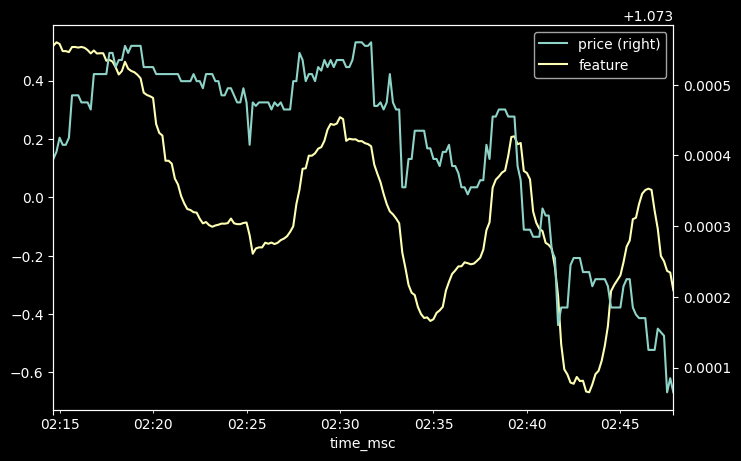

In [12]:
summary.set_index("time_msc",inplace=True)
summary = summary[["price","feature"]]
summary.iloc[800:1000].plot(secondary_y='price', figsize=(8, 5))